In [20]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [21]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure 4 is based on several important BED-files ...

In [23]:
feat_names = OrderedDict()
feat_names["ctcf_ddx55"] = "IAA-CTCF-narrowPeak-withDDX55-centered-CTCF"
feat_names["ctcf"] = "IAA-CTCF-narrowPeak-noDDX55-centered-CTCF"
feat_names["ddx55"] = "IAA-DDX55-narrowPeak-noCTCF-centered-DDX55"


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [24]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


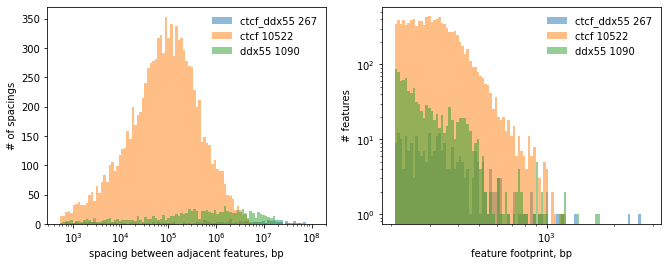

In [25]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [26]:
#let's describe our samples that we want to have in Figure 1 ...
fig4_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","ddx_CTCF","ddx_noCTCF","mrna_ctcf","mrna_noctcf"]

titles = fig4_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig4_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [27]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf_ddx55:(267) ...


stacking up ctcf ...
CPU times: user 58.2 ms, sys: 4.17 ms, total: 62.4 ms
Wall time: 61.6 ms
stacking up noctcf ...
CPU times: user 51.4 ms, sys: 3.98 ms, total: 55.4 ms
Wall time: 54.9 ms
stacking up rad21_CTCF ...
CPU times: user 59.6 ms, sys: 0 ns, total: 59.6 ms
Wall time: 60 ms
stacking up rad21_noCTCF ...
CPU times: user 43.1 ms, sys: 3.95 ms, total: 47 ms
Wall time: 46.9 ms
stacking up ins_CTCF ...
CPU times: user 36 ms, sys: 57 µs, total: 36.1 ms
Wall time: 35.5 ms
stacking up ins_noCTCF ...
CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 41.9 ms
stacking up G4a_r2 ...
CPU times: user 64.2 ms, sys: 0 ns, total: 64.2 ms
Wall time: 64.2 ms
stacking up polII ...
CPU times: user 40.2 ms, sys: 0 ns, total: 40.2 ms
Wall time: 40.4 ms
stacking up ddx_CTCF ...
CPU times: user 53.2 ms, sys: 3.91 ms, total: 57.2 ms
Wall time: 56.8 ms
stacking up ddx_noCTCF ...
CPU times: user 50.7 ms, sys: 3.91 ms, total: 54.6 ms
Wall time: 54.6

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [28]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
for feature_key in stackup_dict:
    normalize_insulation_stackups_INPLACE(
        stackups_set = stackup_dict[feature_key],
        ins_keys = insulation_keys
    )

In [29]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [30]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ctcf'].shape
    center_bin = int(width/2)
    the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    # the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('ctcf_mean', "sort", 1, False)],
        idxs = np.arange( len(the_stackups['ctcf_mean']) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 267 elements of ctcf_mean into 1 groups ...
sorting 10522 elements of ctcf_mean into 1 groups ...
sorting 1090 elements of ctcf_mean into 1 groups ...


In [31]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "pcgene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "pcgene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig4_samples.append(feat_name)
titles = fig4_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

stacking genes up for ctcf_ddx55 ...
stacking genes up for ctcf ...
stacking genes up for ddx55 ...


#### plotting those running averages is integrated into `plot_stackups` function ...

In [32]:
feat_names.keys()

odict_keys(['ctcf_ddx55', 'ctcf', 'ddx55'])

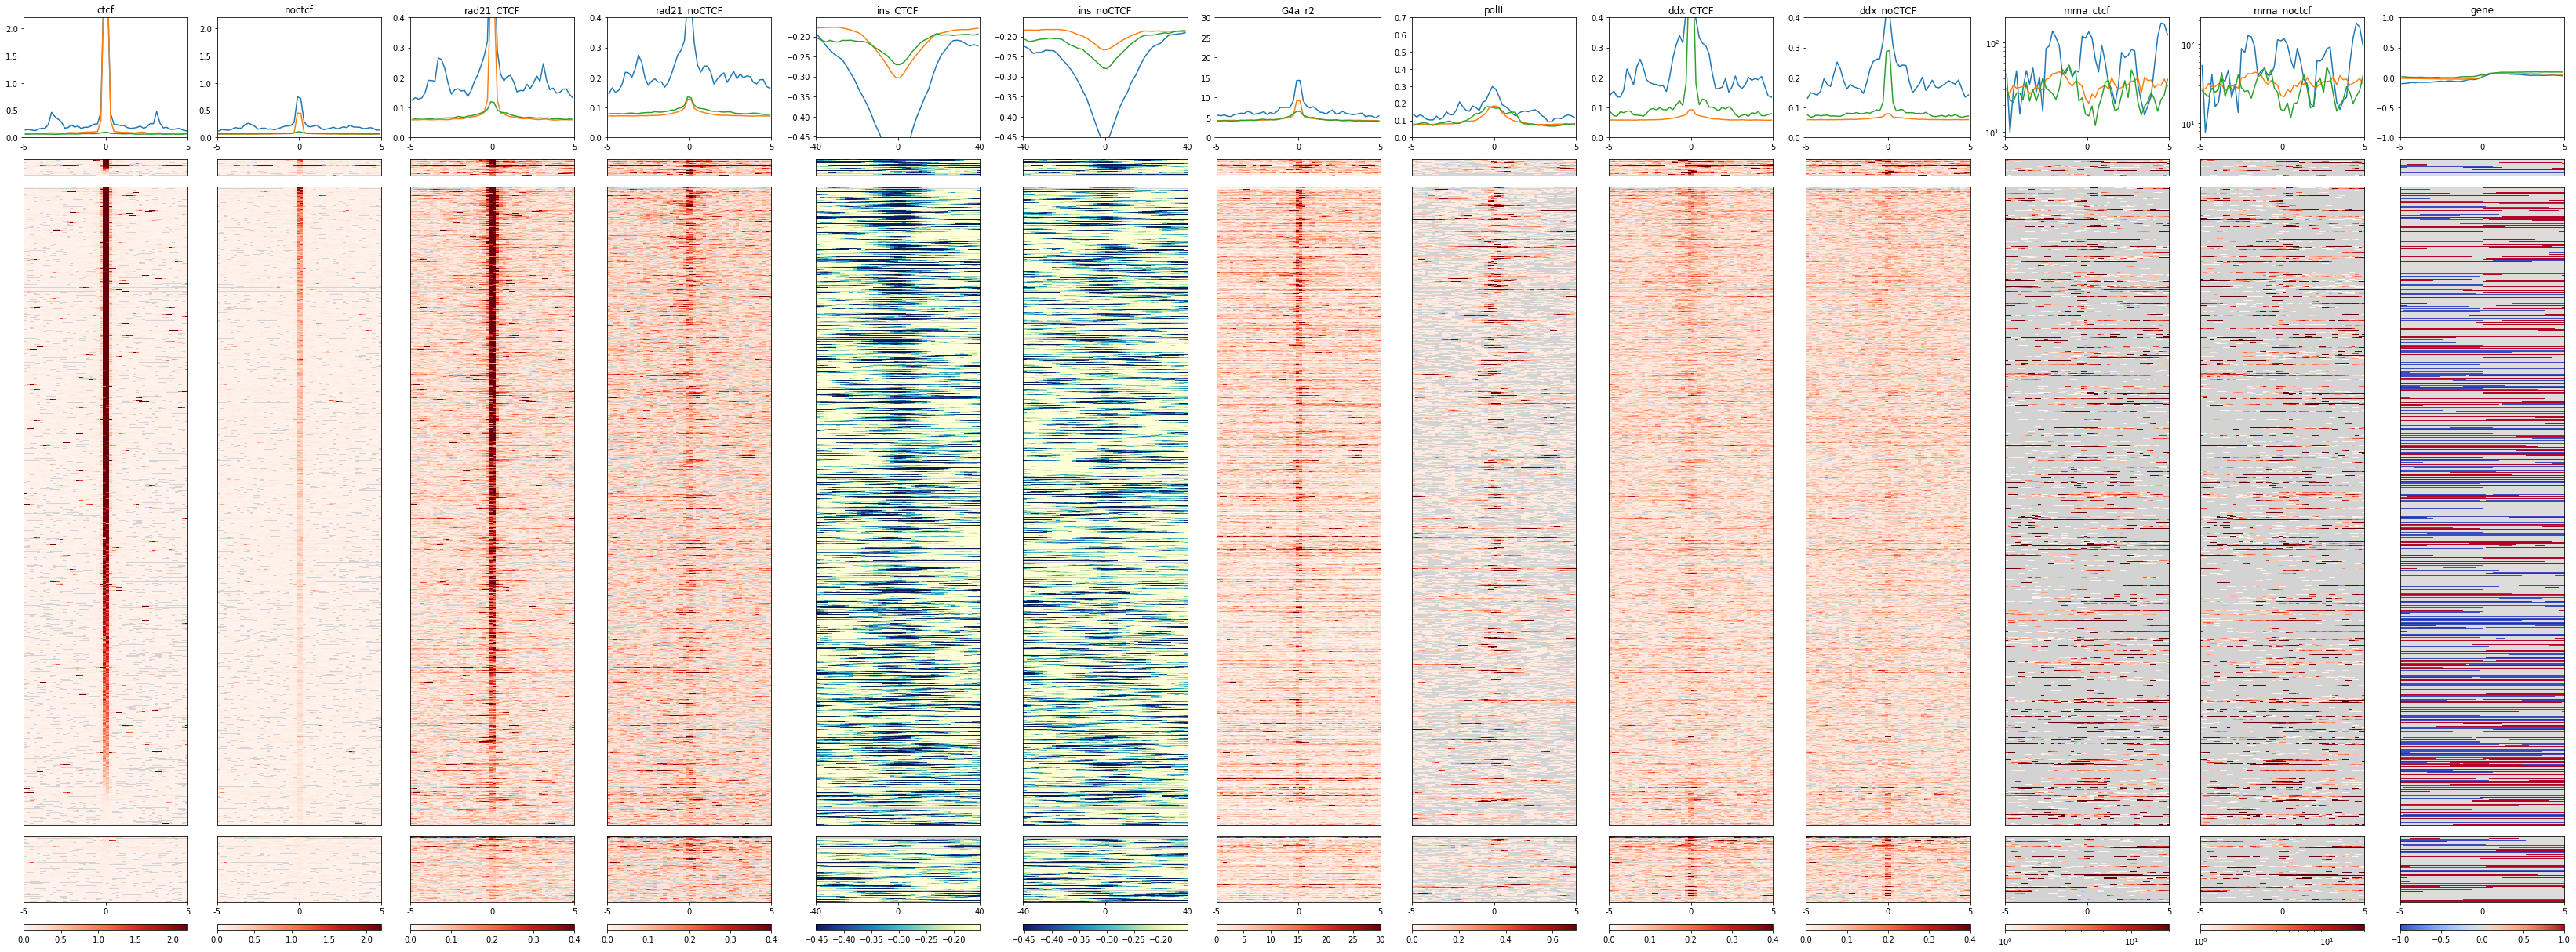

In [33]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig4_samples ]

_limss = [ limss[_k] for _k in fig4_samples ]
_cmps = [ cmps[_k] for _k in fig4_samples ]
_binsizes = [ binsizes[_k] for _k in fig4_samples ]
_norms = [ norms[_k] for _k in fig4_samples ]

# xtra_plots = [1,2]
extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group


In [18]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/